<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/07_introduction_to_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 7: Introduction to MCMC


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 24th, 11:59pm EST

**Names of Group Members**: Chi Zhang: zhangchipku@gmail.com;David Assaraf: davidassaraf@g.harvard.edu; Silin Zou: szou@g.harvard.edu;Varun Tekur: v_tekur@college.harvard.edu; johanneskolberg@g.harvard.edu





## Learning Goals:

1. Explore how to empirically and theoretically verify the correctness of samplers
2. Understand in which ways samplers define or fail to define MCMC samplers for fixed target distributions.


### Load necessary libraries

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

## Problem 1: Samplers for Discrete Distributions

In this problem, we explore samplers for discrete distributions. The target distribution is a categorical distribution $\mathrm{Cat}(\phi)$, $\phi = [0.1, 0.6, 0.3]$. We will explore several samplers for the target distribution. 

We first consider the following sampler:

#### **Sampler #0**
Fix a target distribution $p(\theta)$ over $\Theta$ and a proposal distribution $q(\theta | \theta_{\text{old}})$ over $\Theta$:

1. **Step 0:** choose an initial value $\theta_0 \in \Theta$.
2. **Step 1:** repeat for $S$ number of steps:
  - **Proposal:** propose a sample $\theta_{\text{prop}} \sim q(\theta | \theta_{\text{old}})$
  - **Acceptance:** Add $\theta_{\text{prop}}$ to list of accepted samples

For proposal distributions, we consider the following:

1. $\theta | \theta_{\text{old}} = \mathrm{round}(X)$, where $\mathrm{round}$ is operation of roundint to the nearest integer, and $X \sim \mathrm{U}(\max(0, \theta_{\text{old}} - 1), \min(2, \theta_{\text{old}} + 1))$

2. $\theta | \theta_{\text{old}} = 2X$, where $X \sim \mathrm{Ber}(0.7)$

3. $\theta | \theta_{\text{old}} = \min(2, \max(0, (\theta_{\text{old}} - 1) + 2X))$, where $X \sim \mathrm{Ber}(0.7)$

**Exercise 1:** For each of the proposal distributions, determine if Sampler 1 an MCMC sampler for the target distribution:
0. does the sampler generate a Markov chain?
1. write the transition matrix and/or diagram for the sampler paired with each proposal distribution.
2. empricially check if each proposal distribution generates a Markov chain with a limiting distribution. What theoretical properties of Markov chains gaurantees that these limiting distribution do or do not exist?
3. is the target distribution equal to the limiting distribution?


Below are the transition matrix for each proposal

In [ ]:
t1 = np.array([[0.5,0.5,0],[0.25,0.5,0.25],[0,0.5,0.5]])
print(t1)
t2 = np.repeat([0.3,0,0.7],3).reshape((3,3)).T
print(t2)
t3 = np.array([[0.3,0.7,0],[0.3,0,0.7],[0,0.3,0.7]])
print(t3)

[[0.5  0.5  0.  ]
 [0.25 0.5  0.25]
 [0.   0.5  0.5 ]]
[[0.3 0.  0.7]
 [0.3 0.  0.7]
 [0.3 0.  0.7]]
[[0.3 0.7 0. ]
 [0.3 0.  0.7]
 [0.  0.3 0.7]]


In [ ]:
np.dot(t1,t1)

array([[0.375, 0.5  , 0.125],
       [0.25 , 0.5  , 0.25 ],
       [0.125, 0.5  , 0.375]])

In [ ]:
np.dot(t2,t2)

array([[0.3, 0. , 0.7],
       [0.3, 0. , 0.7],
       [0.3, 0. , 0.7]])

proposal 2 do not depend on previous state. We don't think this is marchov chain. Also there is absorbing states and would never sample state 1. 

In [ ]:
def my_matrix_power(t,n):
  tn=t
  for i in range(n):
    tn=np.dot(tn,t)
  return tn
t_3_20 = my_matrix_power(t3,20)
print(t_3_20)
t_3_100 = my_matrix_power(t3,100)
print(t_3_100)
t_1_20 = my_matrix_power(t1,20)
print(t_1_20)
t_1_100 = my_matrix_power(t1,100)
print(t_1_100)

[[0.11392408 0.26582286 0.62025306]
 [0.11392408 0.26582274 0.62025318]
 [0.11392403 0.26582279 0.62025318]]
[[0.11392405 0.26582278 0.62025316]
 [0.11392405 0.26582278 0.62025316]
 [0.11392405 0.26582278 0.62025316]]
[[0.25000024 0.5        0.24999976]
 [0.25       0.5        0.25      ]
 [0.24999976 0.5        0.25000024]]
[[0.25 0.5  0.25]
 [0.25 0.5  0.25]
 [0.25 0.5  0.25]]


I think proposal 1 and 3 are both marchov chains and the transition matrix multiplied n times goes to stationary with each row giving the same number. That means no matter what state you start with, after n transitions, they end up with the same distribution. So the proposal 1 and 3 give us same limiting distributions as stationary.

None of the proposal distributions using this sampler would give us back the target distribution

In [ ]:
start = np.array([[1,0,0],[0,1,0],[0,0,1]])
def my_sample_p(t=t3, n=30000):
  samples=np.zeros((n,3))
  state = start[np.random.choice(3)]
  for i in range(n):
    p = t.T.dot(state)
    state=np.random.multinomial(1,p)
    samples[i] = state
  return samples

In [ ]:
samples = my_sample_p()
samples.mean(axis=0)


array([0.1144    , 0.26273333, 0.62286667])

In [ ]:
samples[-20:-1]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Sampling from proposal 3, the samples give us a distribuition same as the limiting distribution listed above and the last 20 samples are aperiodic. 

In [ ]:
samples = my_sample_p(t1)
samples.mean(axis=0)

array([0.2521    , 0.49913333, 0.24876667])

In [ ]:
samples[-20:-1]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Sampling from proposal 1, the samples give us a distribuition same as the limiting distribution listed above and the last 20 samples are aperiodic. 

**Exercise 2:** Is it likely that Sampler #0 will be an MCMC sampler for the target distribution for any proposal distribution? Why or why not?

We tested the 3 proposals, 1 and 3 would not give us back the target distribution. 2 would never sample state 1, so none of them would be MCMC sampler for the target distribution

---

Now let's consider two samplers both of which will explicitly take in to account the target distribution $p$ when determining whether or not to accept a proposed sample:

#### **Sampler #1**
Fix a target distribution $p(\theta)$ over $\Theta$ and a proposal distribution $q(\theta | \theta_{\text{old}})$ over $\Theta$:

1. **Step 0:** choose an initial value $\theta_0 \in \Theta$.
2. **Step 1:** repeat for $S$ number of steps:
  - **Proposal:** propose a sample $\theta_{\text{prop}} \sim q(\theta | \theta_{\text{old}})$
  - **Accept/Reject:** 
    - generate $U \sim U(0, 1)$
    - generate accept "probability": 
    $$\alpha(\theta_{\text{prop}}, \theta_{\text{old}}) = \min\left(1, \frac{p(\theta_{\text{prop}})}{p(\theta_{\text{old}})}\right)$$
    - if $U < \alpha(\theta_{\text{prop}}, \theta_{\text{old}})$: 
      - add $\theta_{\text{prop}}$ to list of accepted samples
      - set $\theta_{\text{old}} \leftarrow \theta_{\text{prop}}$ 
    - else: 
      add $\theta_{\text{old}}$ to list of accepted samples

#### **Sampler #2**
Fix a target distribution $p(\theta)$ over $\Theta$ and a proposal distribution $q(\theta | \theta_{\text{old}})$ over $\Theta$:

1. **Step 0:** choose an initial value $\theta_0 \in \Theta$.
2. **Step 1:** repeat for $S$ number of steps:
  - **Proposal:** propose a sample $\theta_{\text{prop}} \sim q(\theta | \theta_{\text{old}})$
  - **Accept/Reject:** 
    - generate $U \sim U(0, 1)$
    - generate accept "probability": 
    $$\alpha(\theta_{\text{prop}}, \theta_{\text{old}}) = \min\left(1, \frac{p(\theta_{\text{prop}})/q(\theta_{\text{prop}} | \theta_{\text{old}})}{p(\theta_{\text{old}})/ q(\theta_{\text{old}}| \theta_{\text{prop}})}\right)$$
    - if $U < \alpha(\theta_{\text{prop}}, \theta_{\text{old}})$: 
      - add $\theta_{\text{prop}}$ to list of accepted samples
      - set $\theta_{\text{old}} \leftarrow \theta_{\text{prop}}$ 
    - else: 
      add $\theta_{\text{old}}$ to list of accepted samples

**Exercise 3:** For the proposal distribution

$$
\theta | \theta_{\text{old}} = \min(2, \max(0, (\theta_{\text{old}} - 1) + 2X)), \text{ where } X \sim \mathrm{Ber}(0.7),
$$

determine whether or not each of the above samplers is an MCMC sampler for the target distribution.

What about for the proposal distribution

$$
\theta | \theta_{\text{old}} = \mathrm{round}(X)
$$

where  $\mathrm{round}$ is operation of roundint to the nearest integer, and  $X \sim \mathrm{U}(\max(0, \theta_{\text{old}} - 1), \min(2, \theta_{\text{old}} + 1))$.



In [ ]:
p = np.array([0.1,0.6,0.3])
def my_sampler1(t=t3, n=3000):
  samples=np.zeros((n,3))
  state = start[np.random.choice(3)]
  for i in range(n):
    p_old = np.dot(state,p)
    q = t.T.dot(state)
    new_state=np.random.multinomial(1,q)
    p_new = np.dot(new_state,p)
    u = np.random.uniform()
    if u < p_new/p_old:
      state = new_state
    samples[i] = state
  return samples

def my_sampler2(t=t3, n=3000):
  samples=np.zeros((n,3))
  state = start[np.random.choice(3)]
  for i in range(n):
    p_old = np.dot(state,p)
    q_old_state = t.T.dot(state)
    new_state=np.random.multinomial(1,q_old_state)
    p_new = np.dot(new_state,p)
    q_new = np.dot(new_state, q_old_state)
    q_new_state = t.T.dot(new_state)
    q_old = np.dot(state, q_new_state)
    u = np.random.uniform()
    if u < p_new/q_new/(p_old/q_old):      
      state = new_state
    samples[i] = state
  return samples

In [ ]:
samples = my_sampler1()
samples.mean(axis=0)

array([0.03833333, 0.436     , 0.52566667])

we start with proposal 3 with sampler 1, we see the average sample probabilities are not the same as target distribution. so proposal 3 with sampler 1 would not give us a sampler for target distribution

In [ ]:
samples = my_sampler2()
samples.mean(axis=0)

array([0.10466667, 0.597     , 0.29833333])

we start with proposal 3 with sampler 2, we see the average sample probabilities are close to target distribution. so proposal 3 with sampler 2 would give us a sampler for target distribution

In [ ]:
samples = my_sampler1(t1)
samples.mean(axis=0)

array([0.06566667, 0.76      , 0.17433333])

With proposal 1 with sampler 1, we see the average sample probabilities are not the same as target distribution. so proposal 1 with sampler 1 would not give us a sampler for target distribution

In [ ]:
samples = my_sampler2(t1)
samples.mean(axis=0)

array([0.09566667, 0.614     , 0.29033333])

with proposal 1 with sampler 2, we see the average sample probabilities are close to target distribution. so proposal 1 with sampler 2 would give us a sampler for target distribution

In [ ]:
samples = my_sampler2(t2)
samples.mean(axis=0)

array([0.24766667, 0.        , 0.75233333])

with proposal 2 with sampler 2, we see the average sample probabilities are not the same as target distribution. so proposal 2 with sampler 2 would not give us a sampler for target distribution

---

## Problem 2: Samplers for Continuous Distributions

In this problem, we explore samplers for continuous distributions. We consider Sampler #1 and #2 from Problem 1.


In [ ]:
# sampler 1
def sampler_1(S, target, init, proposal_distribution):
  samples = []
  current = init
  accepts = 0
  for s in range(S):
      proposal = proposal_distribution(current)
      U = np.random.uniform(0, 1)
      
      if U < np.min((1, target(proposal) / target(current))):
          samples.append(proposal)
          current = proposal
          accepts += 1
      else:
          samples.append(current)
  return samples, accepts * 1. / S

# sampler 2
def sampler_2(S, target, init, proposal_distribution, proposal_pdf):
  samples = []
  current = init
  accepts = 0
  for s in range(S):
      proposal = proposal_distribution(current)
      U = np.random.uniform(0, 1)
      
      if U < np.min((1, np.exp(np.log(target(proposal)) + np.log(proposal_pdf(current, proposal)) - np.log(target(current)) - np.log(proposal_pdf(proposal, current))))):
          samples.append(proposal)
          current = proposal
          accepts += 1
      else:
          samples.append(current)
  return samples, accepts * 1. / S

We will consider two target distributions, a standard normal distribution 

In [ ]:
#define the target distribution as a univariate gaussian
target_sigma_sq = 1.
target_mu = 0.
target_1 = lambda x: sp.stats.norm(target_mu, target_sigma_sq**0.5).pdf(x)

#define the target distribution as a mixture of two univariate gaussians
sigma_sqs = [1, 1]
mus = [2, 6]
pis = [0.5, 0.5]
target_2 = lambda x: pis[0] * sp.stats.norm(mus[0], sigma_sqs[0]**2).pdf(x) + pis[1] * sp.stats.norm(mus[1], sigma_sqs[1]**2).pdf(x)

We will begin by considering a proposal distribution: $\mathcal{N}(\theta_{\mathrm{old}}, 0.6)$ and a gamma distribution with mean 4.

In [ ]:
#define the proposal distribution variance
proposal_sigma_sq = 0.5

#define the proposal distribution sampler
proposal_distribution = lambda mean: np.random.normal(mean, proposal_sigma_sq**0.5, size=1)[0]
#define the proposal distribution pdf
proposal_pdf = lambda x, mean: sp.stats.norm(mean, proposal_sigma_sq**0.5).pdf(x)

We run each sampler on each target distribution.

In [ ]:
#number of samples
S = 1000
#initial state
init = 10
#run sampler 1 on target distribution 1
samples_11, accept_rate_11 = sampler_1(S, target_1, init, proposal_distribution)

In [ ]:
#run sampler 2 on target distribution 1
samples_12, accept_rate_12 = sampler_1(S, target_2, init, proposal_distribution)

In [ ]:
#run sampler 2 on target distribution 1
samples_21, accept_rate_21 = sampler_2(S, target_1, init, proposal_distribution, proposal_pdf)

In [ ]:
#run sampler 2 on target distribution 2
samples_22, accept_rate_22 = sampler_2(S, target_2, init, proposal_distribution, proposal_pdf)

We visualize each set of samples again the corresponding target distribution.

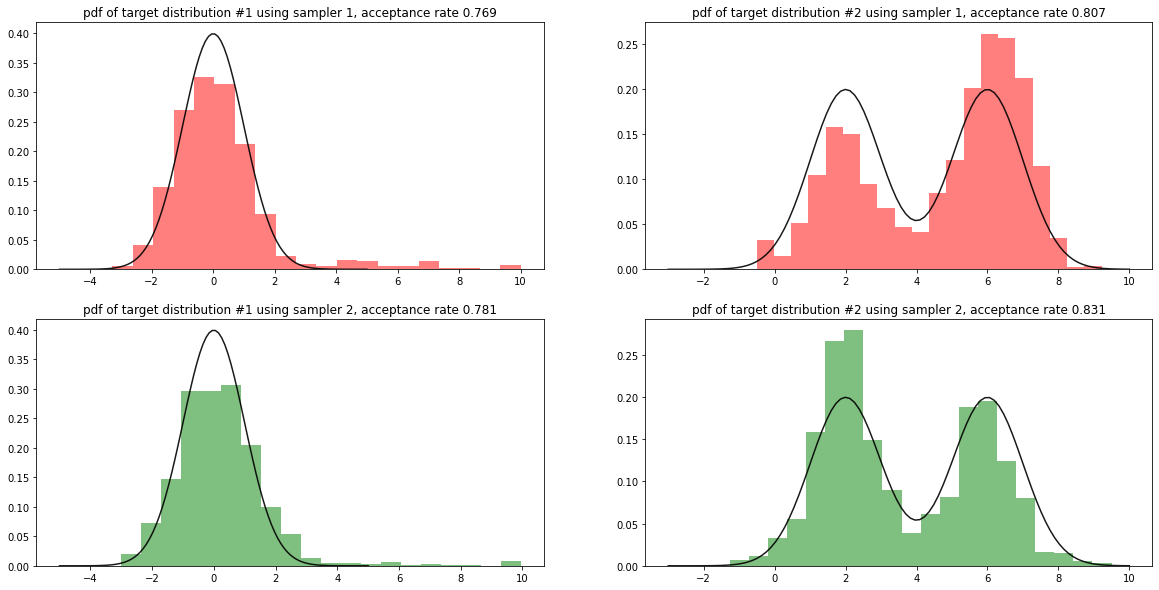

In [ ]:
#visualize the target distributions against the samples from the samplers
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

#visualize target distribution #1 against samples from sampler #1
x = np.linspace(-5, 5, 100)
ax[0, 0].plot(x, target_1(x), color='black', alpha=0.9)
ax[0, 0].hist(samples_11, color='red', bins=20, density=True, alpha=0.5)

#visualize target distribution #1 against samples from sampler #2
ax[1, 0].plot(x, target_1(x), color='black', alpha=0.9)
ax[1, 0].hist(samples_21, color='green', bins=20, density=True, alpha=0.5)

#visualize target distribution #2 against samples from sampler #1
x = np.linspace(-3, 10, 100)
ax[0, 1].plot(x, target_2(x), color='black', alpha=0.9)
ax[0, 1].hist(samples_12, color='red', bins=20, density=True, alpha=0.5)

#visualize target distribution #2 against samples from sampler #2
ax[1, 1].plot(x, target_2(x), color='black', alpha=0.9)
ax[1, 1].hist(samples_22, color='green', bins=20, density=True, alpha=0.5)

ax[0, 0].set_title('pdf of target distribution #1 using sampler 1, acceptance rate {}'.format(accept_rate_11))
ax[0, 1].set_title('pdf of target distribution #2 using sampler 1, acceptance rate {}'.format(accept_rate_12))
ax[1, 0].set_title('pdf of target distribution #1 using sampler 2, acceptance rate {}'.format(accept_rate_21))
ax[1, 1].set_title('pdf of target distribution #2 using sampler 2, acceptance rate {}'.format(accept_rate_22))
plt.show()

**Exercise 4:** In Problem 1, you proved that, in the discrete case, Sampler 2 is an MCMC sampler for the target distribution of interest, where as Sampler 1 may not be (depending on the proposal distribution). Does that continue to be the case for continuous distributions?

Modify the example code provided above to test these two samplers on the two target distributions for the following proposal distributions:

1. $\mathcal{N}(\theta_{\mathrm{old}}, 0.5)$
2. $\mathrm{Ga}(\theta_{\mathrm{old}} + 2, 1)$, where the mean is $\theta_{\mathrm{old}} + 2$
3. $\mathrm{U}(\theta_{\mathrm{old}} - 1, \theta_{\mathrm{old}} + 1)$

Which sampler, in combination with which proposal distribution, do you think is an MCMC sampler? Why?

In [ ]:
#define the proposal distribution variance
proposal_sigma_sq = 0.6

#define the proposal distribution sampler
proposal_distribution1 = lambda mean: np.random.normal(mean, proposal_sigma_sq**0.5, size=1)[0]
#define the proposal distribution pdf
proposal_pdf1 = lambda x, mean: sp.stats.norm(mean, proposal_sigma_sq**0.5).pdf(x)

#define the proposal distribution sampler
proposal_distribution2 = lambda mean: np.random.gamma(mean+2, 1, size=1)[0]
#define the proposal distribution pdf
proposal_pdf2 = lambda x, mean: sp.stats.gamma(mean+2).pdf(x)

#define the proposal distribution sampler
proposal_distribution3 = lambda mean: np.random.uniform(mean-1, mean+1, size=1)[0]
#define the proposal distribution pdf
proposal_pdf3 = lambda x, mean: sp.stats.uniform(mean-1, 2).pdf(x)

In [ ]:
def my_compare(proposal_distribution, proposal_pdf, S = 1000, init = 4):

  #run sampler 1 on target distribution 1
  samples_11, accept_rate_11 = sampler_1(S, target_1, init, proposal_distribution)
  #run sampler 2 on target distribution 1
  samples_12, accept_rate_12 = sampler_1(S, target_2, init, proposal_distribution)
  #run sampler 2 on target distribution 1
  samples_21, accept_rate_21 = sampler_2(S, target_1, init, proposal_distribution, proposal_pdf)
  #run sampler 2 on target distribution 2
  samples_22, accept_rate_22 = sampler_2(S, target_2, init, proposal_distribution, proposal_pdf)
  #visualize the target distributions against the samples from the samplers
  fig, ax = plt.subplots(2, 2, figsize=(20, 10))

  #visualize target distribution #1 against samples from sampler #1
  x = np.linspace(-5, 5, 100)
  ax[0, 0].plot(x, target_1(x), color='black', alpha=0.9)
  ax[0, 0].hist(samples_11, color='red', bins=20, density=True, alpha=0.5)

  #visualize target distribution #1 against samples from sampler #2
  ax[1, 0].plot(x, target_1(x), color='black', alpha=0.9)
  ax[1, 0].hist(samples_21, color='green', bins=20, density=True, alpha=0.5)

  #visualize target distribution #2 against samples from sampler #1
  x = np.linspace(-3, 10, 100)
  ax[0, 1].plot(x, target_2(x), color='black', alpha=0.9)
  ax[0, 1].hist(samples_12, color='red', bins=20, density=True, alpha=0.5)

  #visualize target distribution #2 against samples from sampler #2
  ax[1, 1].plot(x, target_2(x), color='black', alpha=0.9)
  ax[1, 1].hist(samples_22, color='green', bins=20, density=True, alpha=0.5)

  ax[0, 0].set_title('pdf of target distribution #1 using sampler 1, acceptance rate {}'.format(accept_rate_11))
  ax[0, 1].set_title('pdf of target distribution #2 using sampler 1, acceptance rate {}'.format(accept_rate_12))
  ax[1, 0].set_title('pdf of target distribution #1 using sampler 2, acceptance rate {}'.format(accept_rate_21))
  ax[1, 1].set_title('pdf of target distribution #2 using sampler 2, acceptance rate {}'.format(accept_rate_22))
  plt.show()

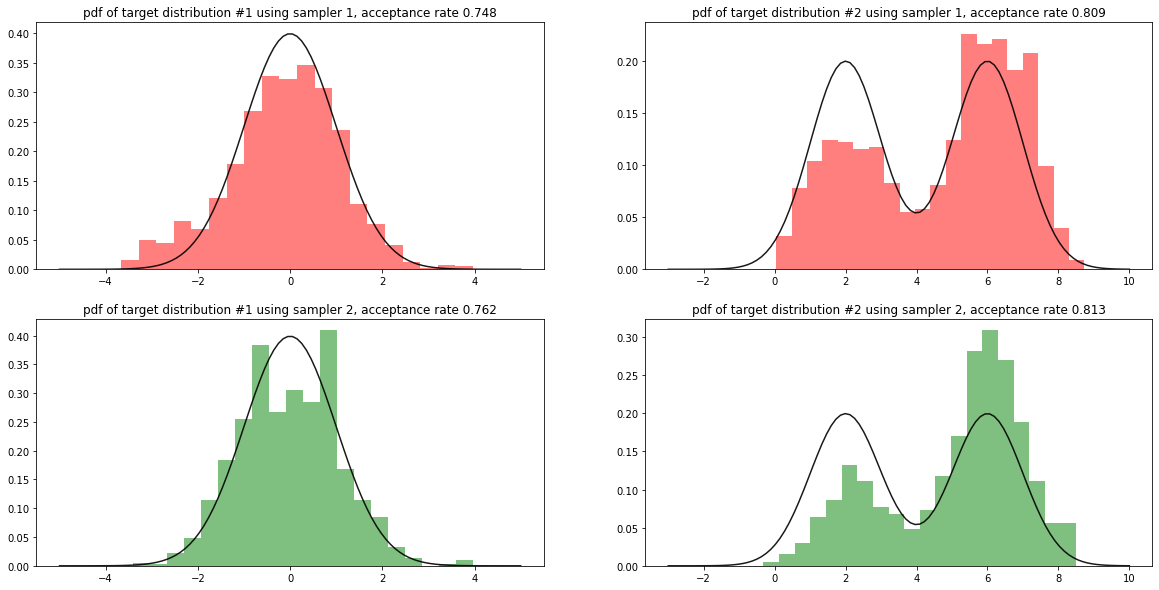

In [ ]:
my_compare(proposal_distribution1, proposal_pdf1)

Using standard gaussian as proposal, both sampler 1 and sample 2 give us similar samples for target 1. but for target 2, the samples we get are not ideal, they are not balanced between the two mixture distributions. 

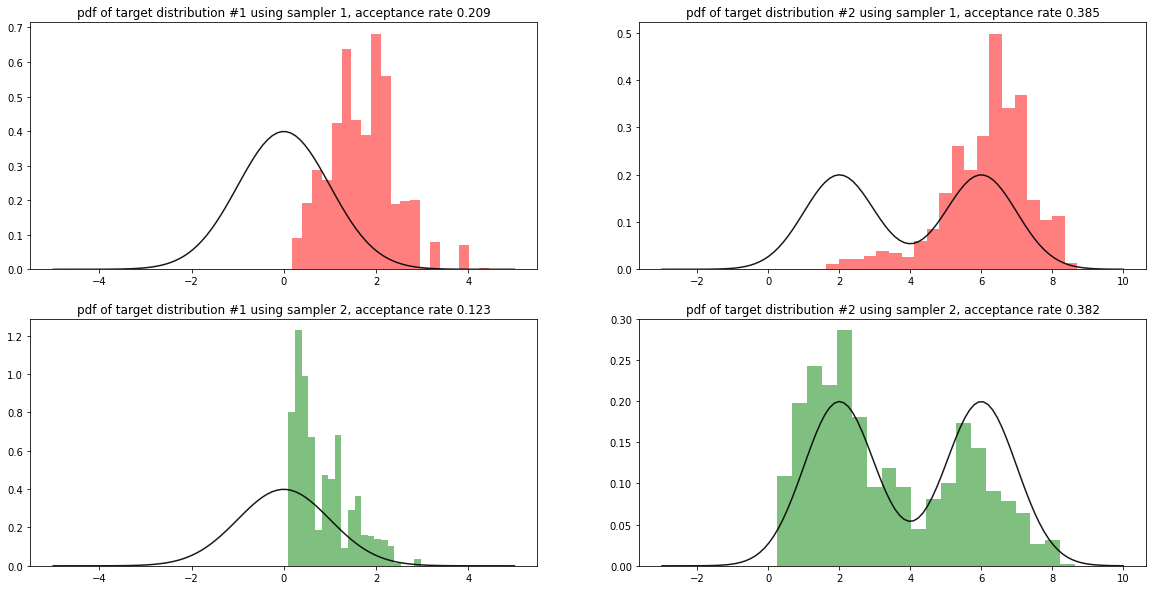

In [ ]:
my_compare(proposal_distribution2, proposal_pdf2)

with a gamma distribution as proposal, gamma would only give us positive samples and both sample 1 and 2 failed to generate target distribution. sampler 2 tried to mimcik the target only on the positive side. 

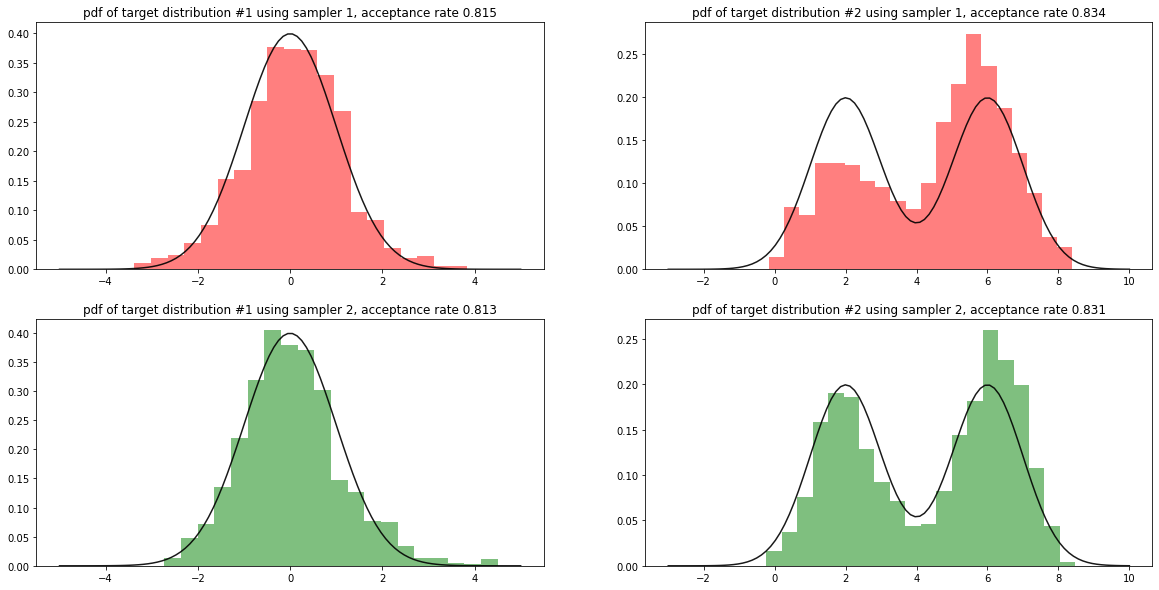

In [ ]:
my_compare(proposal_distribution3, proposal_pdf3)

For the uniform proposal, we get back target 1 in both sampler1 and sampler 2. for target 2, the sampler 1 and sampler 2 looks similar and performed better than the normal proposal distribution, probably because uniform is more likely to sample points further away from previous state and is more likely to travel across the low density portion of the gaussian mixture.  